In [2]:
import pandas
x = pandas.read_csv('train.csv',index_col='id')
y = x['loss'].values

categoryColumnNames = [c for c in x.columns if c.startswith('cat')]
convertedX = pandas.get_dummies(x,drop_first=True,columns = categoryColumnNames)
goodColumnNames = [l for l in convertedX.columns if l not in ('id','loss')]
X = convertedX.loc[:,goodColumnNames].values


In [29]:
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot
ytransform = numpy.sqrt(y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)


maes =[]
def meanAbsErrorByComponents(components, hidden_layer, X_train, X_test, y_train, y_test):
    pca = PCA(n_components=components)
    
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    #X_train = StandardScaler().fit_transform(X_train)
    X_test = pca.transform(X_test)
    #X_test = StandardScaler().fit_transform(X_test)
    reg =  MLPRegressor(hidden_layer_sizes=hidden_layer)
    reg.fit(X_train,y_train)
    y_pred = reg.predict(X_test)
    y_pred = y_pred**2
    mae = sum(abs(y_pred-(y_test)**2))/y_pred.shape[0]
    #mae = sum(abs(y_pred-(y_test)))/y_pred.shape[0]
    return mae
for i in range(10):#100,200,5):
    X_train, X_test, y_train, y_test = train_test_split(X, ytransform, test_size=0.20)
    X_train20000 = X_train[:20000,:]
    y_train20000 = y_train[:20000]
    t = time.time()
    m =  meanAbsErrorByComponents(115,(150,), X_train20000, X_test, y_train20000, y_test)
    elapsed = time.time()-t
    maes.append(m)
    print (i,m,elapsed)
matplotlib.pyplot.plot(maes)
matplotlib.pyplot.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0 1352.37938831 63.636780738830566
1 1349.36131209 62.934173822402954


KeyboardInterrupt: 

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.decomposition import PCA
import time
# Fit estimators
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=50,  max_features=32, 
                                       criterion='mae'),
    "K-nn": KNeighborsRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "MLP":  MLPRegressor(hidden_layer_sizes=(150,))
}

y_test_predict = {}

for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(name)
    if name in ('K-nn','MLP',"Linear regression"):
        if name == 'MLP':
            components = 115
        elif name == 'K-nn':
            components = 40
        else:
            components = 115
        pca = PCA(n_components=components)
    
        pca.fit(X_train)
        X_train_ = pca.transform(X_train)
        X_test_ = pca.transform(X_test)
    else:
        X_train_ = X_train
        X_test_ = X_test
    estimator.fit(X_train_, y_train)
    
    t_1 = time.time()
    print(f'Time elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[name] = estimator.predict(X_test_)
    print(f'Time elapsed for prediction {time.time() - t_1:.3f} sec')
    error = numpy.sum(numpy.abs(y_test_predict[name] - y_test)) / len(y_test)
    print(f'error: {error:.3f}')


Extra trees


In [ ]:
y_test_predict = {}
for i in range(1,61):
    pca = PCA(n_components=i)
    
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    #X_train = StandardScaler().fit_transform(X_train)
    X_test = pca.transform(X_test)
    t_0 = time.time()
    print(i)
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'Time elapsed for fitting of model {t_1 - t_0:.3f} sec')
    y_test_predict[i] = estimator.predict(X_test)
    print(f'Time elapsed for prediction {time.time() - t_1:.3f} sec')
    
for components, y_hat in y_test_predict.items():
    error = numpy.sum(numpy.abs(y_hat - y_test)) / len(y_test)
    print(f'{components}, error: {error:.3f}')

In [6]:
import numpy
for name, y_hat in y_test_predict.items():
    error = numpy.sum(numpy.abs(y_hat - y_test)) / len(y_test)
    print(f'{name}, error: {error:.3f}')

Extra trees, error: 1319.217
Linear regression, error: 67458088965.851
Ridge, error: 1308.665
MLP, error: 1194.157


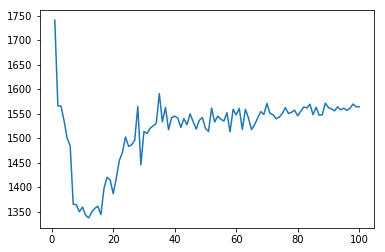

In [14]:
import matplotlib.pyplot

matplotlib.pyplot.plot(range(1,101),maes)
matplotlib.pyplot.show()

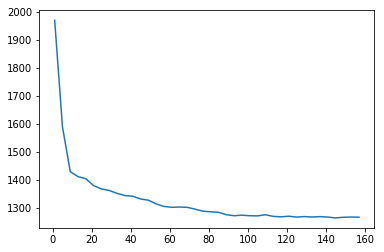

In [23]:
#This shows that adding PCA components beyond >115 does not have much effect.
matplotlib.pyplot.plot(range(1,161,4),maes)
matplotlib.pyplot.show()